In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
pd.read_csv('sample_submission.csv').head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [7]:
X = train_df['message']
y = train_df['sentiment']

In [8]:
anti = train_df[y==-1]
neutral = train_df[y==0]
pro = train_df[y==1]
news = train_df[y==2]

y.value_counts()


 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

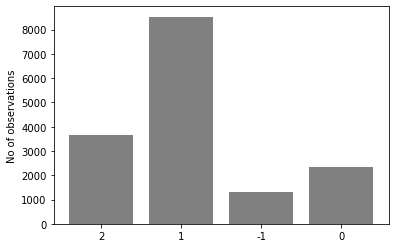

In [9]:
labels = y.unique()
heights = [len(anti),len(neutral),len(pro),len(news)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['-1','0','1','2'])
plt.ylabel("No of observations")
plt.show()

Data Cleaning

In [10]:
#Setting the resamples to half the size of the majority sample
#sample_size = int(len(pro)/2)

# Downsample majority
#downsampled = resample(pro,replace=False,n_samples=sample_size,random_state=42)
# Upsample minority
#upsampled = resample(neutral,replace=True,n_samples=sample_size,random_state=42)
#upsampled2 = resample(anti,replace=True,n_samples=sample_size,random_state=42)
#upsampled3 = resample(news,replace=True,n_samples=sample_size,random_state=42)

#train_df = pd.concat([downsampled,upsampled,upsampled2,upsampled3])
#train_df['sentiment'].value_counts()

In [11]:
#anti = train_df[train_df['sentiment']==-1]
#neutral = train_df[train_df['sentiment']==0]
#pro = train_df[train_df['sentiment']==1]
#news = train_df[train_df['sentiment']==2]
#labels = train_df['sentiment'].unique()
#heights = [len(anti),len(neutral),len(pro),len(news)]
#plt.bar(labels,heights,color='grey')
#plt.xticks(labels,['-1','0','1','2'])
#plt.ylabel("# of observations")
#plt.show()

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
#If we get url maybe we can extract text data from the urls
def get_url(sent):
    pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    return ''.join(re.findall(pattern,sent))
train_df['url'] = train_df['message'].apply(get_url)
test_df['url'] = test_df['message'].apply(get_url)
train_df.head()

,sentiment,message,tweetid,url
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,https://t.co/yeLvcEFXkC
1,1,It's not like we lack evidence of anthropogeni...,126103,
2,2,RT @RawStory: Researchers say we have three ye...,698562,https://t.co/WdT0KdUr2fhttps://t.co/Z0ANPT
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,https://t.co/44wOTxTLcD
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,


In [14]:
def remove_url(df):
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    url = r'url-web'
    df['message'] = df['message'].replace(to_replace = pattern_url, value = url, regex = True)
    return df

In [15]:
train_df = remove_url(train_df)
test_df = remove_url(test_df)

In [16]:
# add RT as a stopword
for word in ['RT','https','http']:
    nlp.Defaults.stop_words.add(word)
    nlp.vocab[word].is_stop = True

In [23]:
def clean_message(message):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z\t])|(\w+:\/\/\S+)"," ",message).split())

train_df['message'] = train_df['message'].apply(clean_message)
test_df['message'] = test_df['message'].apply(clean_message)

In [24]:
#Remove all punctuation in message column
def remove_punctuation(message):
    punct = string.punctuation +'0123456789'
    return ''.join([l for l in message if l not in punct])
train_df['message'] = train_df['message'].apply(remove_punctuation)
test_df['message'] = test_df['message'].apply(remove_punctuation)

In [25]:
def lemma_text(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

train_df['message'] = train_df['message'].apply(lemma_text)
test_df['message'] = test_df['message'].apply(lemma_text)

#Data Cleaned

In [26]:
X = train_df['message']
tfidf = TfidfVectorizer(strip_accents='ascii',stop_words='english',min_df=0.001,ngram_range=(1,2))
X_vectorized = tfidf.fit_transform(X)

In [27]:
smote = SMOTE(random_state =42)
X_vect_smote, y_smote = smote.fit_sample(X_vectorized,y)

In [28]:
len(y_smote)

34120

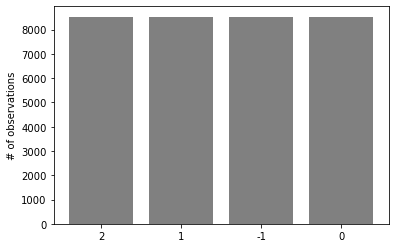

In [29]:
anti = y_smote[y_smote==-1]
neutral = y_smote[y_smote==0]
pro = y_smote[y_smote==1]
news = y_smote[y_smote==2]
labels = y_smote.unique()
heights = [len(anti),len(neutral),len(pro),len(news)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['-1','0','1','2'])
plt.ylabel("# of observations")
plt.show()

In [30]:
print(tfidf.get_feature_names())


['abandon', 'abc', 'abortion', 'absolutely', 'abt', 'accelerate', 'accept', 'accept climate', 'accord', 'account', 'acknowledge', 'act', 'act climate', 'action', 'action beforetheflood', 'action climate', 'action url', 'activist', 'activity', 'actonclimate', 'actually', 'ad', 'adapt', 'adapt climate', 'adaptation', 'add', 'address', 'address climate', 'admin', 'administration', 'administrator', 'admit', 'advance', 'advisory', 'advocate', 'affect', 'affect climate', 'affect pron', 'africa', 'ag', 'age', 'age pron', 'agency', 'agenda', 'ago', 'agree', 'agree climate', 'agreement', 'agreement climate', 'agreement url', 'agriculture', 'ahead', 'aim', 'air', 'air pollution', 'al', 'al gore', 'alarm', 'alarmist', 'alaska', 'alia', 'allow', 'alter', 'america', 'america country', 'america pron', 'american', 'americans', 'amid', 'amp', 'amp climate', 'amp global', 'amp pron', 'anemone', 'anemone cracks', 'angry', 'angry caller', 'animal', 'animal agriculture', 'announce', 'answer', 'antarctica'

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_vect_smote, y_smote)

In [32]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    MLPClassifier()
]

In [ ]:
results = []

models = {}
confusion = {}
class_report = {}

names = ['Logistic Regression', 'Nearest Neighbors',
         'SVM','Decision Tree', 'Random Forest','AdaBoost Classifier','MLPClassifier']
for clf, name in zip(classifiers, names):
    model = clf
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    
    f1 = metrics.f1_score(y_val, y_pred, average='macro')
    results.append([name, f1])
results = pd.DataFrame(results, columns=['Classifier', 'F1 Score'])  

C:\Users\Mathew\anaconda3\envs\Climate_Change_Belief_Analysis\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
results.sort_values('F1 Score', ascending=False)

In [ ]:
X_test = test_df['message']
test_vectorized = tfidf.transform(X_test)

In [ ]:
#X_test_df = test_df['message']

In [ ]:
#test_vectorized = tfidf.transform(X_test_df)

In [ ]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mlp_val_pred = mlp.predict(X_val)
f1 = metrics.f1_score(y_val, mlp_val_pred, average='macro')
f1

In [ ]:
mlp_test_pred = mlp.predict(test_vectorized)

In [ ]:
test_df['sentiment'] = mlp_test_pred
test_df[['tweetid','sentiment']].to_csv('MLP_test_89.csv', index=0)

In [ ]:
best_params = {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}

In [ ]:
#params = {}
#grid = GridSearchCV()